In [ ]:
import env
import numpy as np
import agents_gpu as agents
import copy
import torch as tr
from torch import nn
from matplotlib import pyplot as plt

C:\Users\NiSz\Anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
sa = agents.StepAgent(lr = 0.1, state_shape = (11, 11, 4))
sa.loadnet(tr.load('valuenetdict_step_deep.pt'))

In [ ]:
batch_size = 1
envs = [env.GridWorld(size = 11, n_target = 10) for i in range(batch_size)]

  # # # # # # # # # # # 
  #     r       X     # 
  #       r           # 
  #                   # 
  #   r               # 
  # r           2   # # 
  #       r     r   # # 
  #                 # # 
  # r           r   # # 
  #                 # # 
  # # # # # # # # # # #  


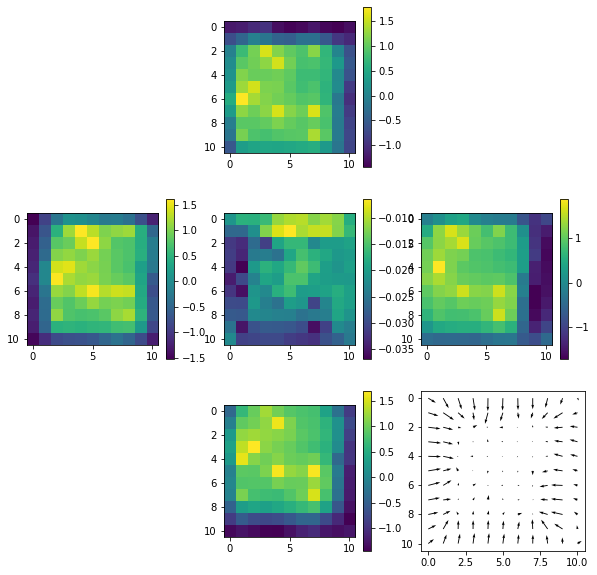

In [ ]:
ie = 0

obs = envs[ie].observe()
vmap = np.zeros([11, 11])
vecmap = np.zeros([11, 11, 4])
for i in range(11):
    for j in range(11):
        obs[0, :,:,2] = 0
        obs[0,i,j, 2] = 1
        state = tr.tensor(obs).permute([0,3,1, 2]).float().cuda()
        sa.policy.eval()
        va = sa.policy(state)
        va = va.cpu().detach().numpy()
        vmap[i,j] = va[0, 0]#va.mean()
        vecmap[i,j] = va[0, 1:]

print(envs[ie])
plt.figure(figsize = [10, 10])
plt.subplot(3,3,5)
plt.imshow(vmap)
#plt.clim([-1, 1])
plt.colorbar()
lplt = [2, 8, 4, 6]
for i in range(4):
    plt.subplot(3,3,lplt[i])
    plt.imshow(vecmap[:,:,i])
    #plt.clim([-1, 1])
    plt.colorbar()
    # plt.clim([-2, -1])
    
    
plt.subplot(3,3,9)
vec = vecmap[:,:,[0,2]]-vecmap[:,:,[1,3]]
vec[:,:,1] = -vec[:,:,1]
# plt.quiver(x.flatten(),y.flatten(),vec[:,:,1].flatten(), vec[:,:,0].flatten(), scale = 10)
plt.quiver(vec[:,:,1], vec[:,:,0], scale = 30)
plt.gca().invert_yaxis()
#plt.clim([-2, 2])
#plt.colorbar()
#plt.savefig("policy.svg")
    
    
    
plt.savefig("valuemap.svg")

In [ ]:
%%time
sa = agents.StepAgent(lr = 0.1, state_shape = (11, 11, 4))
batch_size = 128

In [ ]:
%%time
rewardss = []
ws = []
for i in range(500):
    envs = [env.GridWorld(size = 11, n_target = 10) for i in range(batch_size)]
    ws.append(copy.deepcopy(sa.policy.fc.weight))
    obs = np.zeros([batch_size, 2, 11, 11, 4])
    for ie, e in enumerate(envs):
        e.reset()
        obs[ie] = e.observe()
    states = tr.tensor(obs[:, 0, :, :, :]).permute([0, 3, 1, 2]).float().cuda()
    for istep in range(30):
        act = sa.act(states)
        # acts.append(act)
        
        obs = np.zeros([batch_size, 2, 11, 11, 4])
        rewards = np.zeros([batch_size])
        dones = np.zeros([batch_size])
        for ie, e in enumerate(envs):
            _obs, reward, done = e.step([act[ie, 0].item(), 0])
            obs[ie,:,:,:,:] = _obs
            rewards[ie] = reward
            dones[ie] = done
        re = np.sum(rewards)
        rewards = tr.tensor(rewards).float().cuda()
        states = tr.tensor(obs[:, 0, :, :, :]).permute([0, 3, 1, 2]).float().cuda()
        dones = tr.tensor(dones).float().cuda()
        
        sa.reward(rewards, states)
        #if done:
        #    break
        sa.train()
    sa.reset()
    rewardss.append(re)
# print(np.array([i for i in zip(rewards.cpu().detach().numpy(), act.cpu().detach().numpy()[:,0])]).T)
tr.save(sa.policy.state_dict(), 'valuenetdict_step_deep.pt')